In [2]:
import sys
from pathlib import Path

# Add project root to Python path
PROJECT_ROOT = Path.cwd().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

print("Added to sys.path:", PROJECT_ROOT)

Added to sys.path: /Users/croberts/practice-telemetry-ml


In [3]:
import pandas as pd

from src.config import PROCESSED_DIR

features_path = PROCESSED_DIR / "telemetry_features.parquet"

In [4]:
df_feat = pd.read_parquet(features_path)
df_feat.head()

,device_id,timestamp,sensor_value,temp_c,battery_v,rssi,event_tag,sensor_value_lag_1,sensor_value_lag_2,sensor_value_lag_4,...,rssi_roll_max_12,rssi_roll_mean_24,rssi_roll_std_24,rssi_roll_min_24,rssi_roll_max_24,rssi_roll_mean_96,rssi_roll_std_96,rssi_roll_min_96,rssi_roll_max_96,sensor_value_delta_1
0,D000,2025-12-12 21:32:00,9.858728,19.683805,3.900091,-54.144628,normal,9.565351,9.393019,10.021016,...,-44.637861,-54.845883,3.063186,-58.158349,-44.637861,-54.943067,2.853510,-62.836587,-44.637861,0.172332
1,D000,2025-12-12 21:47:00,10.795045,21.500761,3.887863,-56.141875,normal,9.858728,9.565351,9.152039,...,-44.637861,-54.721945,3.027174,-58.158349,-44.637861,-54.928992,2.854088,-62.836587,-44.637861,0.293376
2,D000,2025-12-12 22:02:00,10.109577,20.561263,3.891643,-50.739916,normal,10.795045,9.858728,9.393019,...,-44.637861,-54.677826,2.997043,-58.158349,-44.637861,-54.923194,2.851018,-62.836587,-44.637861,0.936317
3,D000,2025-12-12 22:17:00,10.522814,22.815123,3.903879,-60.523109,normal,10.109577,10.795045,9.565351,...,-44.637861,-54.419623,3.060238,-58.158349,-44.637861,-54.873286,2.882032,-62.836587,-44.637861,-0.685467
4,D000,2025-12-12 22:32:00,11.624841,21.366689,3.902865,-54.717040,normal,10.522814,10.109577,9.858728,...,-44.637861,-54.741333,3.280698,-60.523109,-44.637861,-54.932725,2.939134,-62.836587,-44.637861,0.413236


In [5]:
df_feat.shape

(28357, 68)

In [6]:
non_feature_cols = {"device_id", "timestamp", "event_tage"}

feature_cols = [
    c for c in df_feat.columns
    if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df_feat[c])
]

len(feature_cols), feature_cols[:10]

(65,
 ['sensor_value',
  'temp_c',
  'battery_v',
  'rssi',
  'sensor_value_lag_1',
  'sensor_value_lag_2',
  'sensor_value_lag_4',
  'sensor_value_lag_8',
  'temp_c_lag_1',
  'temp_c_lag_2'])

In [8]:
df_feat[feature_cols].isna().any().any()

np.True_

In [7]:
na_counts = df_feat[feature_cols].isna().sum().sort_values(ascending=False)
na_counts.head(20)

sensor_value           28
temp_c_roll_std_4       0
temp_c_roll_max_4       0
temp_c_roll_mean_12     0
temp_c_roll_std_12      0
temp_c_roll_min_12      0
temp_c_roll_max_12      0
temp_c_roll_mean_24     0
temp_c_roll_std_24      0
temp_c_roll_min_24      0
temp_c_roll_max_24      0
temp_c_roll_mean_96     0
temp_c_roll_std_96      0
temp_c_roll_min_96      0
temp_c_roll_max_96      0
rssi_roll_mean_4        0
rssi_roll_std_4         0
rssi_roll_min_4         0
rssi_roll_max_4         0
rssi_roll_mean_12       0
dtype: int64

In [9]:
from sklearn.ensemble import IsolationForest

In [10]:
x = df_feat[feature_cols]

iso = IsolationForest(
    n_estimators=200, 
    max_samples="auto", 
    contamination=0.02, 
    random_state=42,
    n_jobs=1
)

In [11]:
iso.fit(x)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",200
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.02
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [14]:
df_feat["anomaly_score"] = iso.decision_function(x)
df_feat["anomaly_pred"] = iso.predict(x)

In [15]:
df_feat["anomaly_score"].head()

0    0.050544
1    0.054887
2    0.065916
3    0.051263
4    0.071515
Name: anomaly_score, dtype: float64

Matplotlib is building the font cache; this may take a moment.


<Axes: >

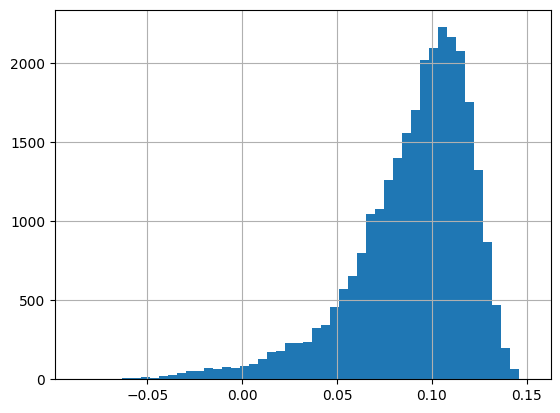

In [16]:
df_feat["anomaly_score"].hist(bins=50)

In [17]:
df_feat.groupby("event_tag")["anomaly_score"].describe()

,count,mean,std,min,25%,50%,75%,max
event_tag,,,,,,,,
normal,28071.0,0.089962,0.031495,-0.086768,0.074844,0.096665,0.112188,0.150795
spike,84.0,0.077690,0.030050,-0.016262,0.060717,0.082503,0.101181,0.123283
step,40.0,0.078160,0.025378,0.026978,0.060612,0.078134,0.098973,0.127002
variance,162.0,0.061915,0.021209,-0.019850,0.050007,0.062625,0.076933,0.111459
